In [1]:
import pandas as pd
import seaborn as sns

sns.set_theme(style="darkgrid")

In [2]:
DATA_LOCATION = "data"
FILENAME = "attack-effectiveness-"

def get_filename(name):
    return f"{DATA_LOCATION}/{FILENAME}{name}.csv"

get_filename("xcit")

'data/attack-effectiveness-xcit.csv'

In [3]:
def relative_diff(x1, x2):
    return (x2 - x1) / x1

In [4]:
pd.read_csv(get_filename("xcit"))[["adv_loss", "attack_steps", "epoch", "seed"]]

,adv_loss,attack_steps,epoch,seed
0,8.971067,1,0,0
1,9.481953,2,0,0
2,9.857929,5,0,0
3,9.999073,10,0,0
4,10.102695,200,0,0
...,...,...,...,...
160,2.125561,1,99,2
161,2.201465,2,99,2
162,2.246325,5,99,2
163,2.261384,10,99,2


In [5]:
def process_df(model_name):
    filename = get_filename(model_name)
    raw_df = pd.read_csv(filename)
    raw_df["epoch"] = raw_df["epoch"] + 1
    raw_df = raw_df[raw_df["epoch"] != 1]
    processed_df = (
        raw_df[["adv_loss", "attack_steps", "epoch", "seed"]]
            .pivot(["epoch", "seed"], columns='attack_steps', values='adv_loss')
    )
    return processed_df

df = process_df("xcit")
df.head()

attack_steps       1         2         5         10        200
epoch seed                                                    
10    0       3.731684  3.777879  3.802710  3.811381  3.821058
      1       3.732345  3.777894  3.802700  3.811361  3.821043
      2       3.732348  3.777875  3.802695  3.811375  3.821025
20    0       3.416565  3.467899  3.495501  3.505017  3.515385
      1       3.417367  3.467891  3.495504  3.505006  3.515369

In [6]:
def compute_relative_differences(df, attack_steps=(1, 2, 5, 10), wrt=200):
    rel_diffs_df = pd.DataFrame(index=df.index)
    for s1 in attack_steps:
        rel_diffs_df[f"{s1}"] = relative_diff(df[s1], df[wrt])
    return rel_diffs_df
                 

compute_relative_differences(df).head()

1         2         5        10
epoch seed                                        
10    0     0.023950  0.011430  0.004825  0.002539
      1     0.023765  0.011421  0.004824  0.002540
      2     0.023759  0.011422  0.004820  0.002532
20    0     0.028924  0.013693  0.005689  0.002958
      1     0.028678  0.013691  0.005683  0.002957

In [7]:
def compute_attack_effectiveness(model_name):
    df = process_df(model_name)
    relative_diffs_df = compute_relative_differences(df)
    return relative_diffs_df

xcit_rel_diffs = compute_attack_effectiveness("xcit")
xcit_rel_diffs["model"] = "xcit_s_12"

resnet_rel_diffs = compute_attack_effectiveness("resnet")
resnet_rel_diffs["model"] = "resnet50"

convnext_rel_diffs = compute_attack_effectiveness("convnext")
convnext_rel_diffs["model"] = "convnext_t"

In [8]:
overall_df = pd.concat([resnet_rel_diffs, xcit_rel_diffs, convnext_rel_diffs]).reset_index()
overall_df.head()

,epoch,seed,1,2,5,10,model
0,10,0,0.031027,0.017798,0.009035,0.004912,resnet50
1,10,1,0.029403,0.017789,0.009017,0.004900,resnet50
2,10,2,0.029400,0.017791,0.009021,0.004903,resnet50
3,20,0,0.037916,0.021899,0.010982,0.005927,resnet50
4,20,1,0.036714,0.021887,0.010982,0.005927,resnet50


<AxesSubplot:xlabel='epoch', ylabel='1'>

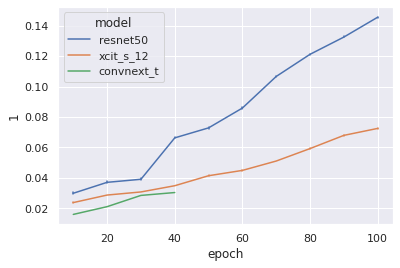

In [9]:
sns.lineplot(x="epoch", y="1", hue="model", data=overall_df, err_style="bars")

In [10]:
overall_df[overall_df["epoch"] == 100].drop("epoch", axis=1)

,seed,1,2,5,10,model
27,0,0.146075,0.096163,0.049016,0.025574,resnet50
28,1,0.145233,0.096222,0.049142,0.025641,resnet50
29,2,0.145122,0.096144,0.049049,0.025558,resnet50
57,0,0.072886,0.035362,0.014694,0.007924,xcit_s_12
58,1,0.072328,0.035363,0.014698,0.007881,xcit_s_12
59,2,0.072297,0.035325,0.014649,0.007893,xcit_s_12


In [11]:
last_epoch_df = overall_df.melt(id_vars=["model", "seed", "epoch"], var_name="steps", value_name="relative_diff")
last_epoch_df.head()

,model,seed,epoch,steps,relative_diff
0,resnet50,0,10,1,0.031027
1,resnet50,1,10,1,0.029403
2,resnet50,2,10,1,0.029400
3,resnet50,0,20,1,0.037916
4,resnet50,1,20,1,0.036714


<AxesSubplot:xlabel='steps', ylabel='relative_diff'>

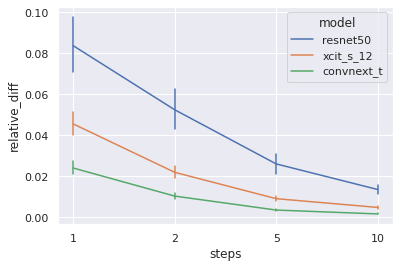

In [12]:
sns.lineplot(x="steps", y="relative_diff", hue="model", data=last_epoch_df, err_style="bars")

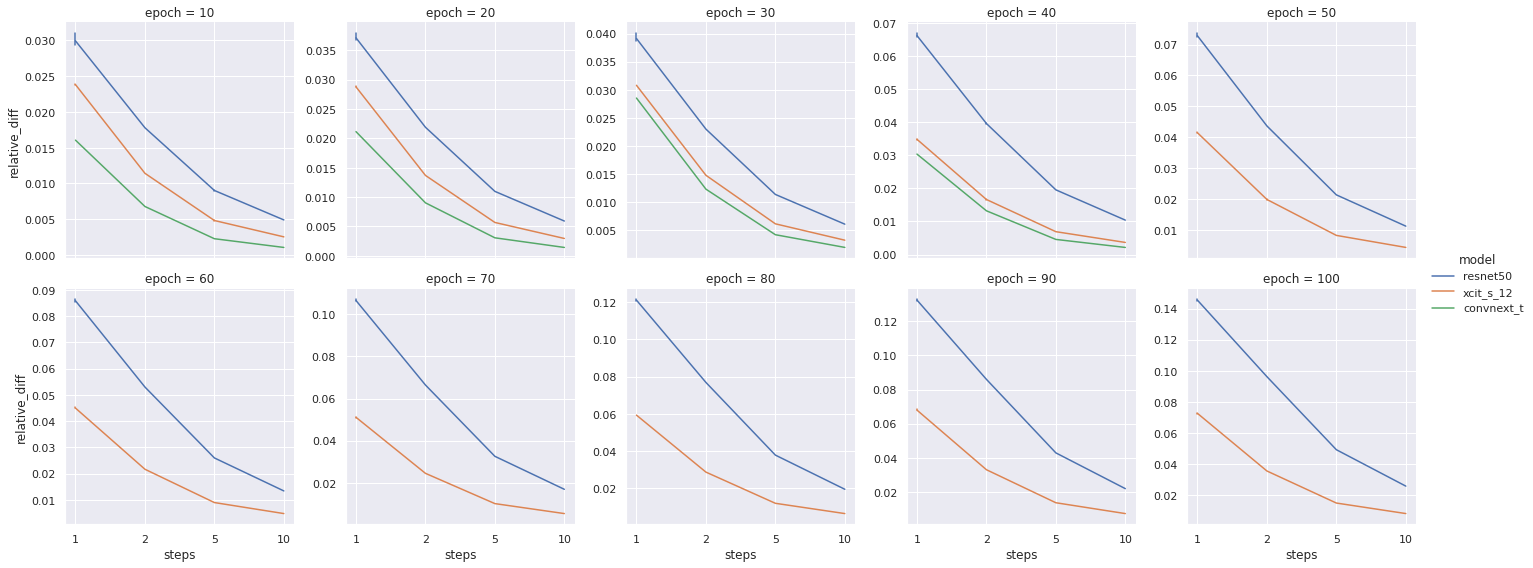

In [13]:
g = sns.FacetGrid(last_epoch_df, col="epoch", hue="model", col_wrap=5, height=4, sharey=False)
g.map(sns.lineplot, "steps", "relative_diff", err_style="bars")
g.add_legend()

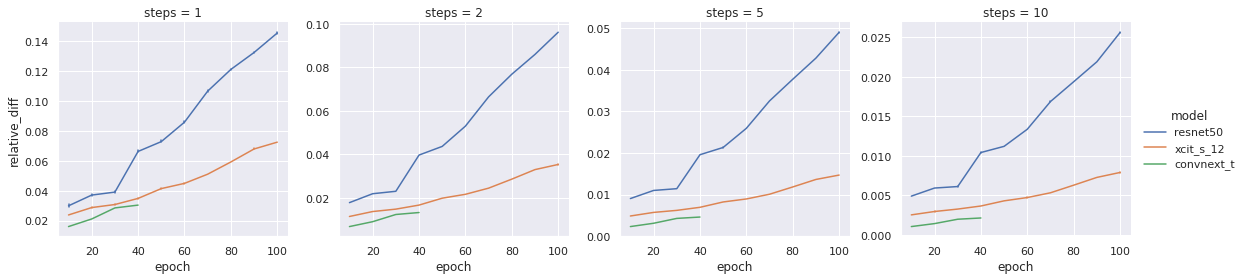

In [14]:
g = sns.FacetGrid(last_epoch_df, col="steps", hue="model", height=4, sharey=False)
g.map(sns.lineplot, "epoch", "relative_diff", err_style="bars")
g.add_legend()